## WOMARS regionalization

**WOMARS** stands for **W**orldwide **M**arine **R**adioactivity **S**tudies.

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd

from shapely.geometry import Polygon, Point
from pysal.lib import weights
from libpysal.weights import w_subset
import h3

from palettable.tableau import Tableau_10
import folium
import seaborn as sns
import contextily

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score

from functools import partial
from pathlib import Path

# from matplotlib import colors
import matplotlib.pyplot as plt


## Data loading

In [ ]:
fname = Path.home() / 'pro/data/maris/190130 Seawater10m_Sediment_1991-2000.xlsx'
df = pd.read_excel(fname, sheet_name='Seawater_137Cs'); df.shape

(4553, 25)

In [ ]:
df.head()

,sample_id,ref_id,samptype_id,longitude,latitude,begperiod,sampdepth,nuclide_id,unit_id,detection,...,wetwt,note,id,featurecla,scalerank,min_zoom,id_year,activity_corrected,"activity,MDA/2","activity,xMDA"
0,69003,99,1,126.650000,27.966667,1991-01-08,0.0,33,1,=,...,NaN,NaN,2,2,0,0,2_1991,2.764260,2.764260,2.764260
1,69004,99,1,125.000000,24.000000,1991-01-10,0.0,33,1,=,...,NaN,NaN,4,4,0,0,4_1991,1.951489,1.951489,1.951489
2,116132,100,1,10.283333,54.483333,1991-01-10,0.0,33,1,=,...,NaN,NaN,22,22,0,0,22_1991,55.129551,55.129551,55.129551
3,116133,100,1,11.150000,54.600000,1991-01-10,0.0,33,1,=,...,NaN,NaN,22,22,0,0,22_1991,52.121006,52.121006,52.121006
4,116134,100,1,11.750000,54.416667,1991-01-10,0.0,33,1,=,...,NaN,NaN,21,21,0,0,21_1991,59.520400,59.520400,59.520400


### Data selection & preprocessing

In [ ]:
df['begperiod'] = pd.to_datetime(df['begperiod'])
df = df[['longitude', 'latitude', 'begperiod', 'activity,MDA/2']]
df.columns = ['lon', 'lat', 'time', 'activity']

In [ ]:
df.head()

,lon,lat,time,activity
0,126.650000,27.966667,1991-01-08,2.764260
1,125.000000,24.000000,1991-01-10,1.951489
2,10.283333,54.483333,1991-01-10,55.129551
3,11.150000,54.600000,1991-01-10,52.121006
4,11.750000,54.416667,1991-01-10,59.520400


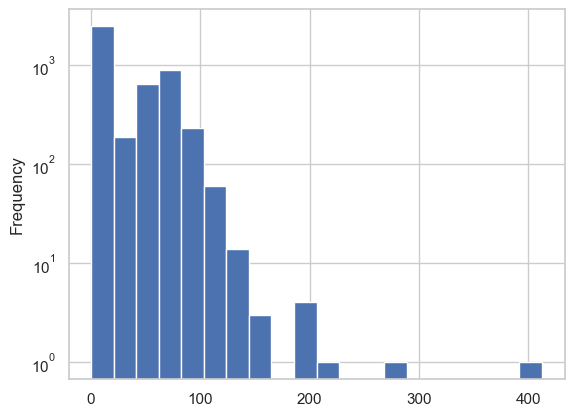

In [ ]:
df['activity'].plot(kind='hist', logy=True,bins=20);  

In [ ]:
geometry = [Point(lon, lat) for lon, lat in zip(df['lon'], df['lat'])]

db = (
    (gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326"))
    .to_crs(epsg=3857)[['time', 'activity', 'geometry']]
    .dropna()
    )
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4553 entries, 0 to 4552
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   time      4553 non-null   datetime64[ns]
 1   activity  4553 non-null   float64       
 2   geometry  4553 non-null   geometry      
dtypes: datetime64[ns](1), float64(1), geometry(1)
memory usage: 106.8 KB


/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


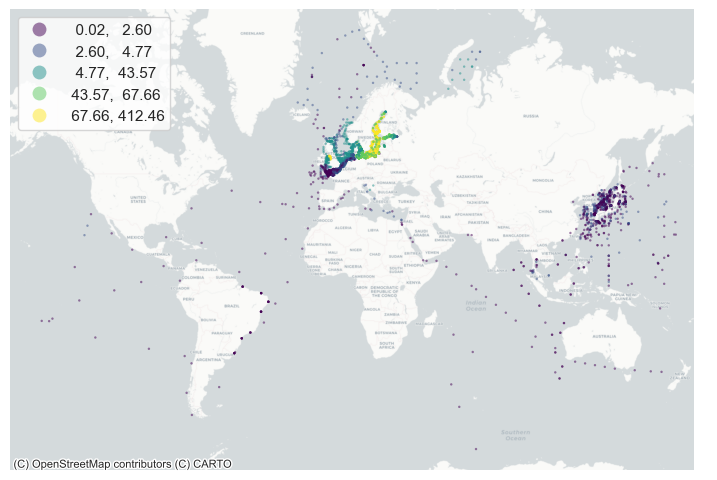

In [ ]:
# Plotting activity
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(
    column="activity",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.5,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
    markersize=3
)
contextily.add_basemap(
    ax,
    crs=db.crs,
    source=contextily.providers.CartoDB.Positron
    
)
ax.set_axis_off()

## H3 encoding

In [ ]:
# https://uber.github.io/h3-py/api_reference
# https://h3geo.org/docs/quickstart
def to_h3(row, resolution=1, lat_col='lat', lon_col='lon'): 
    return h3.latlng_to_cell(row[lat_col], row[lon_col], resolution)

In [ ]:
resolution = 3
df['h3_idx'] = df.apply(partial(to_h3, resolution=resolution), axis=1)

In [ ]:
df.head()

,lon,lat,time,activity,h3_idx
0,126.650000,27.966667,1991-01-08,2.764260,834b1dfffffffff
1,125.000000,24.000000,1991-01-10,1.951489,834babfffffffff
2,10.283333,54.483333,1991-01-10,55.129551,831f06fffffffff
3,11.150000,54.600000,1991-01-10,52.121006,831f00fffffffff
4,11.750000,54.416667,1991-01-10,59.520400,831f00fffffffff


<Axes: ylabel='Frequency'>

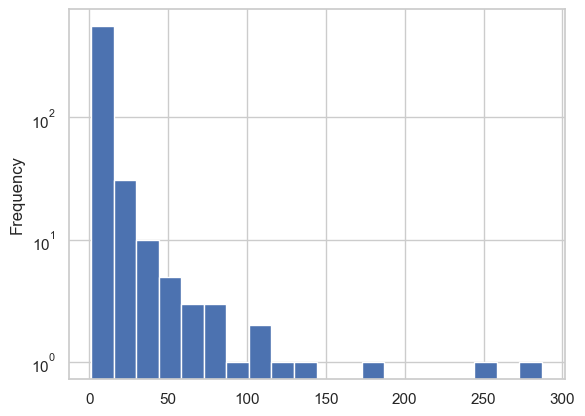

In [ ]:
df['h3_idx'].value_counts().plot(kind='hist', logy=True,bins=20)

In [ ]:
df['activity_log'] = np.log10(df.activity)

In [ ]:
aggregations = {
    'activity_log': [
        ('q1', lambda x: np.percentile(x, 1)),
        ('q2', lambda x: np.percentile(x, 2)),
        ('q3', lambda x: np.percentile(x, 3)),
        ('mean', 'mean'),
        ('min', 'min'),
        ('max', 'max'),
        ('std', lambda x: np.nanstd(x)),
        ('n', 'count')
    ]
}

df_hex = df.groupby('h3_idx').agg(aggregations); df_hex


activity_log                                          \
                          q1        q2        q3      mean       min   
h3_idx                                                                 
8300a2fffffffff     0.666771  0.666771  0.666771  0.666771  0.666771   
8300b0fffffffff     0.445032  0.445032  0.445032  0.445032  0.445032   
8300b1fffffffff     0.494808  0.494924  0.495039  0.500483  0.494692   
8300b4fffffffff     0.808605  0.809797  0.810989  0.867007  0.807413   
830101fffffffff     0.472273  0.472273  0.472273  0.472273  0.472273   
...                      ...       ...       ...       ...       ...   
83caf5fffffffff     0.154164  0.154164  0.154164  0.154164  0.154164   
83ce30fffffffff    -0.266489 -0.266489 -0.266489 -0.266489 -0.266489   
83cf32fffffffff    -0.240608 -0.240608 -0.240608 -0.240608 -0.240608   
83e089fffffffff    -1.058901 -1.058901 -1.058901 -1.058901 -1.058901   
83e111fffffffff    -1.201294 -1.201294 -1.201294 -1.201294 -1.201294   

                                        
                      max       std  n  
h3_idx                                  
8300a2fffffffff  0.666771  0.000000  1  
8300b0fffffffff  0.445032  0.000000  1  
8300b1fffffffff  0.506274  0.005791  2  
8300b4fffffffff  0.926600  0.059593  2  
830101fffffffff  0.472273  0.000000  1  
...                   ...       ... ..  
83caf5fffffffff  0.154164  0.000000  1  
83ce30fffffffff -0.266489  0.000000  1  
83cf32fffffffff -0.240608  0.000000  1  
83e089fffffffff -1.058901  0.000000  1  
83e111fffffffff -1.201294  0.000000  1  

[620 rows x 8 columns]

In [ ]:
# Reset the column names for the result DataFrame if needed
# result.columns = [f'{col[0]} ({col[1]})' for col in result.columns]
df_hex.columns = [f'{col[1]}' for col in df_hex.columns]
df_hex.reset_index(inplace=True)

In [ ]:
df_hex.head()

,h3_idx,q1,q2,q3,mean,min,max,std,n
0,8300a2fffffffff,0.666771,0.666771,0.666771,0.666771,0.666771,0.666771,0.000000,1
1,8300b0fffffffff,0.445032,0.445032,0.445032,0.445032,0.445032,0.445032,0.000000,1
2,8300b1fffffffff,0.494808,0.494924,0.495039,0.500483,0.494692,0.506274,0.005791,2
3,8300b4fffffffff,0.808605,0.809797,0.810989,0.867007,0.807413,0.926600,0.059593,2
4,830101fffffffff,0.472273,0.472273,0.472273,0.472273,0.472273,0.472273,0.000000,1


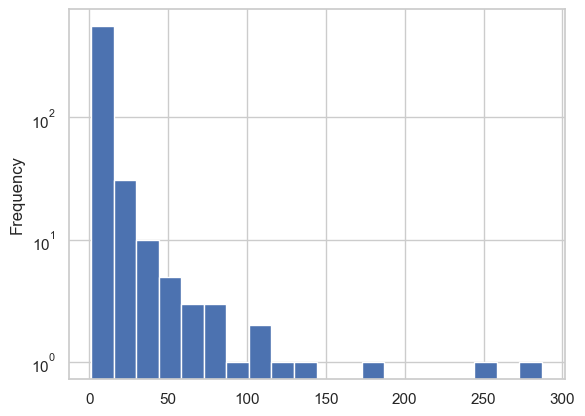

In [ ]:
df_hex.n.plot(kind='hist', logy=True,bins=20);

In [ ]:
def h3_to_polygon(h3_idx):
    h3_idx_geojson = h3.cell_to_boundary(h3_idx, geo_json=True)
    polygon = Polygon(h3_idx_geojson)
    return polygon

In [ ]:
df_hex['geometry'] = df_hex['h3_idx'].apply(h3_to_polygon)

In [ ]:
df_hex.head()

,h3_idx,q1,q2,q3,mean,min,max,std,n,geometry
0,8300a2fffffffff,0.666771,0.666771,0.666771,0.666771,0.666771,0.666771,0.000000,1,"POLYGON ((66.00413859837636 75.44041262884824,..."
1,8300b0fffffffff,0.445032,0.445032,0.445032,0.445032,0.445032,0.445032,0.000000,1,"POLYGON ((70.15375816745133 73.84487699979069,..."
2,8300b1fffffffff,0.494808,0.494924,0.495039,0.500483,0.494692,0.506274,0.005791,2,"POLYGON ((69.87942813932 74.94278794655912, 72..."
3,8300b4fffffffff,0.808605,0.809797,0.810989,0.867007,0.807413,0.926600,0.059593,2,"POLYGON ((67.04817195975174 73.26746640072778,..."
4,830101fffffffff,0.472273,0.472273,0.472273,0.472273,0.472273,0.472273,0.000000,1,"POLYGON ((26.702900751760623 72.8551091339477,..."


## To Geopandas

In [ ]:
gdf = gpd.GeoDataFrame(df_hex, geometry='geometry', crs="EPSG:4326")

In [ ]:
gdf.head()

,h3_idx,q1,q2,q3,mean,min,max,std,n,geometry
0,8300a2fffffffff,0.666771,0.666771,0.666771,0.666771,0.666771,0.666771,0.000000,1,"POLYGON ((66.00414 75.44041, 68.47895 75.48296..."
1,8300b0fffffffff,0.445032,0.445032,0.445032,0.445032,0.445032,0.445032,0.000000,1,"POLYGON ((70.15376 73.84488, 72.40027 73.84025..."
2,8300b1fffffffff,0.494808,0.494924,0.495039,0.500483,0.494692,0.506274,0.005791,2,"POLYGON ((69.87943 74.94279, 72.29417 74.94332..."
3,8300b4fffffffff,0.808605,0.809797,0.810989,0.867007,0.807413,0.926600,0.059593,2,"POLYGON ((67.04817 73.26747, 69.19636 73.29396..."
4,830101fffffffff,0.472273,0.472273,0.472273,0.472273,0.472273,0.472273,0.000000,1,"POLYGON ((26.70290 72.85511, 28.05877 73.22696..."


In [ ]:
# gdf = gdf.to_crs(3857)

In [ ]:
gdf.columns

Index(['h3_idx', 'q1', 'q2', 'q3', 'mean', 'min', 'max', 'std', 'n',
       'geometry'],
      dtype='object')

/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


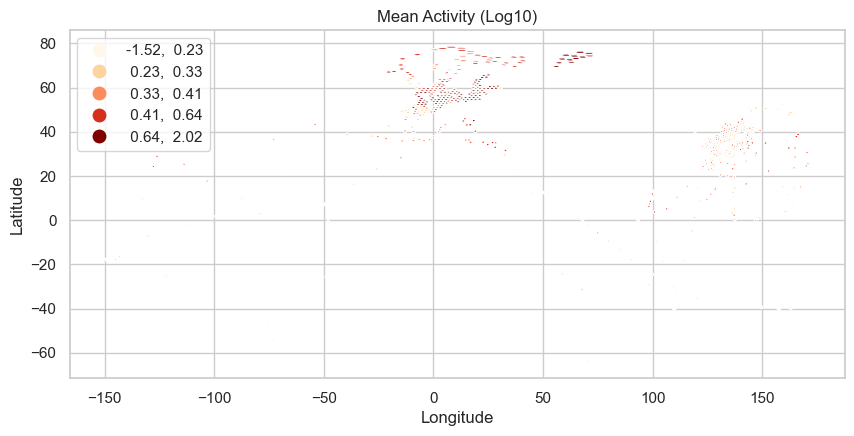

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(ax=ax, column='q2', cmap='OrRd', scheme='quantiles', 
         legend=True, legend_kwds={"loc": 2})

ax.set_title("Mean Activity (Log10)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude");

## Regionalization

### Spatial weights

#### Contiguity

In [ ]:
wq = weights.contiguity.Queen.from_dataframe(gdf)

/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 216 disconnected components.
 There are 179 islands with ids: 23, 25, 27, 34, 36, 37, 44, 45, 79, 81, 82, 85, 86, 119, 120, 123, 124, 126, 127, 128, 147, 171, 179, 214, 216, 220, 256, 257, 258, 337, 338, 361, 395, 399, 400, 401, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 420, 421, 422, 423, 427, 428, 433, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 449, 456, 457, 459, 460, 461, 462, 463, 464, 468, 488, 494, 507, 508, 509, 510, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 532, 533, 534, 535, 536, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 5

In [ ]:
#wq.islands

#### K-nn

In [ ]:
wknn = weights.distance.KNN.from_dataframe(gdf, k=6)

/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


#### Merge (where islands)

In [ ]:
def merge(wq, wknn):
    neighbors = wq.neighbors.copy()
    for i in wq.islands:
        neighbors[i] = list(wknn[i].keys())
    return weights.W(neighbors)

w = merge(wq, wknn)

/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


#### Get disconnected components

In [ ]:
idx_cpt = lambda i: np.where(w.component_labels == i)[0]
w_cpt = lambda i: w_subset(w, idx_cpt(i))

w_cpt(1).neighbors

{4: [8, 5, 7],
 5: [4],
 6: [13, 7],
 7: [4, 13, 6],
 8: [9, 4],
 9: [8, 24],
 13: [6, 7],
 17: [18],
 18: [17, 22],
 19: [21, 22],
 20: [24, 21],
 21: [19, 20],
 22: [18, 19],
 23: [35, 37, 38, 43, 77, 17],
 24: [9, 20],
 25: [83, 20, 19, 84, 21, 24],
 35: [38],
 36: [35, 37, 38, 40, 43, 77],
 37: [35, 36, 38, 40, 43, 77],
 38: [35],
 39: [40],
 40: [39],
 41: [42, 78],
 42: [41],
 43: [77],
 44: [45, 46, 47, 48, 81, 49],
 45: [44, 46, 47, 79, 81, 82],
 46: [48, 49, 47],
 47: [46],
 48: [49, 106, 76, 46],
 49: [48, 106, 46],
 50: [51, 52, 53],
 51: [68, 50, 53, 54, 56],
 52: [66, 50, 53, 58, 62],
 53: [66, 50, 51, 52, 56],
 54: [68, 69, 51, 55, 56],
 55: [73, 75, 69, 54],
 56: [51, 53, 54],
 57: [58, 59, 60, 61, 62, 63],
 58: [66, 67, 52, 57, 60, 62],
 59: [57, 60, 253, 254, 63],
 60: [67, 248, 57, 58, 59],
 61: [57, 63, 62, 239],
 62: [57, 58, 52, 61],
 63: [236, 239, 57, 59, 61, 253],
 64: [65, 66, 67],
 65: [64, 116, 118],
 66: [64, 67, 52, 53, 58],
 67: [64, 66, 248, 58, 60],
 68:

In [ ]:
w_cpt(4).neighbors

{120: [121, 122, 123, 124, 125, 127],
 121: [122],
 122: [121, 125],
 123: [120, 121, 122, 124, 125, 127],
 124: [120, 121, 122, 123, 125, 127],
 125: [122],
 126: [127, 315, 316, 317, 318, 319],
 127: [124, 315, 120, 123, 316, 126],
 215: [217],
 216: [435, 215, 217, 218, 219, 220],
 217: [215],
 218: [219],
 219: [218],
 220: [432, 434, 435, 216, 218, 219],
 259: [277, 262],
 260: [272, 268, 270, 263],
 261: [262, 263, 275, 276, 280],
 262: [259, 261, 276, 277, 279],
 263: [280, 260, 261, 270],
 264: [297, 266, 299],
 265: [273, 266, 325],
 266: [325, 326, 264, 265, 299],
 267: [268, 269, 270],
 268: [260, 267, 269, 270, 272],
 269: [267, 268, 319],
 270: [267, 260, 268, 263],
 271: [272, 273],
 272: [273, 260, 268, 271],
 273: [272, 265, 271],
 274: [275, 276],
 275: [280, 274, 276, 261],
 276: [261, 262, 274, 275, 279],
 277: [259, 262, 279],
 278: [354],
 279: [276, 277, 262],
 280: [275, 261, 263],
 281: [282, 283, 284, 285, 286],
 282: [290, 292, 309, 281, 284, 286],
 283: [294,

## Clustering

In [ ]:
cpt = 4
max_clusters = 10
cols = ['q1', 'q2', 'q3', 'mean', 'min', 'max', 'std']


In [ ]:
X = gdf.iloc[idx_cpt(cpt)][cols].values; X.shape

(319, 7)

In [ ]:
X = gdf.iloc[idx_cpt(cpt)][cols].values
X_t = StandardScaler().fit_transform(X)

for n in range(2, max_clusters+1):
    model = AgglomerativeClustering(
        linkage='ward', 
        connectivity=w_cpt(cpt).sparse,
        n_clusters=n
    )
    model.fit(X_t)
    
    score = calinski_harabasz_score(X_t, model.labels_)
    print(f'# clusters: {n} | score: {score}')

# clusters: 2 | score: 67.28373514736919
# clusters: 3 | score: 68.75815663376504
# clusters: 4 | score: 75.51911416951872
# clusters: 5 | score: 70.13751482011203
# clusters: 6 | score: 69.12202217357948
# clusters: 7 | score: 67.45163791486323
# clusters: 8 | score: 66.1159558757521
# clusters: 9 | score: 65.11531177422033
# clusters: 10 | score: 63.7872287928026


In [ ]:
n_clusters = 3
X = gdf.iloc[idx_cpt(cpt)][cols].values
X_t = StandardScaler().fit_transform(X)

model = AgglomerativeClustering(
    linkage='ward', 
    connectivity=w_cpt(cpt).sparse,
    n_clusters=n_clusters
)

model.fit(X_t)

AgglomerativeClustering(connectivity=<319x319 sparse matrix of type '<class 'numpy.float64'>'
	with 1292 stored elements in Compressed Sparse Row format>,
                        n_clusters=3)

### Visualize

In [ ]:
gdf_sub = gdf.iloc[idx_cpt(cpt),:].copy()
gdf_sub['cluster'] = model.labels_

/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


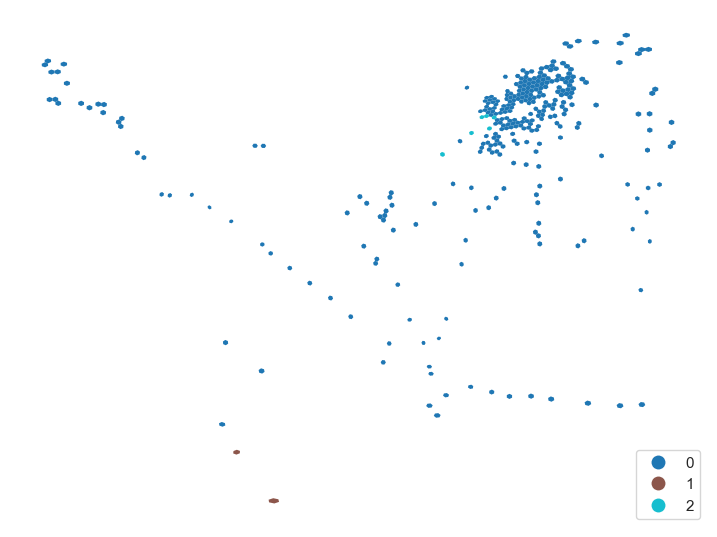

In [ ]:
fig, ax = plt.subplots(1, figsize=(9, 9))
gdf_sub.plot(
    column="cluster",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
    legend_kwds={'loc': 'lower right'}
)

ax.set_axis_off()

In [ ]:
def style_function(feature, n_clusters, prop_name='cluster', palette=Tableau_10):
    attribute_value = feature['properties'][prop_name]
    return {'fillColor': palette.hex_colors[attribute_value], 
            'color': 'none', 
            'fillOpacity': 0.5}

In [ ]:
gdf = gdf_sub.to_crs(epsg=4326)

m = folium.Map(location=[gdf_sub.centroid.y.mean(), 
                         gdf_sub.centroid.x.mean()], zoom_start=3)

geojson_data = gdf_sub.to_json()

folium.GeoJson(geojson_data, style_function=partial(style_function, n_clusters=n_clusters)).add_to(m)

m

/var/folders/9w/q9wj71814bd5m3n9gpmxn1rm0000gn/T/ipykernel_28568/914515011.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[gdf_sub.centroid.y.mean(),
/var/folders/9w/q9wj71814bd5m3n9gpmxn1rm0000gn/T/ipykernel_28568/914515011.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_sub.centroid.x.mean()], zoom_start=3)


/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/9w/q9wj71814bd5m3n9gpmxn1rm0000gn/T/ipykernel_28568/2958626089.py:1: UserWarning: The palette list has more values (10) than n

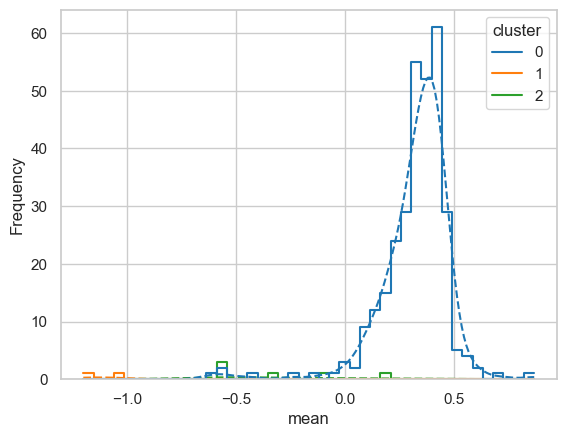

In [ ]:
sns.histplot(data=gdf_sub, x='mean', hue='cluster', 
             fill=False,
             multiple='layer', 
             element='step',
             palette=Tableau_10.mpl_colors,
             kde=True, 
            #  alpha=0.6,
             line_kws={'linestyle': 'dashed', 'alpha': 1}
             )

plt.xlabel('mean')
plt.ylabel('Frequency');

/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

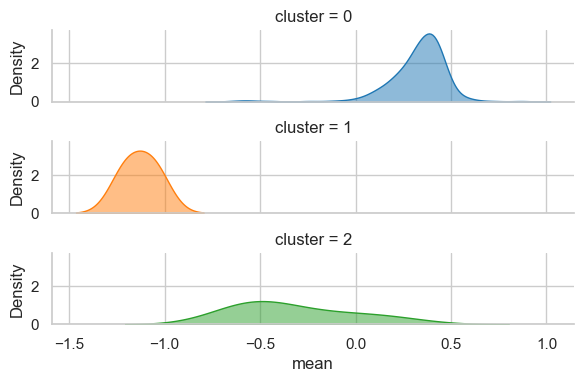

In [ ]:
sns.set(style="whitegrid")
g = sns.FacetGrid(gdf_sub, row='cluster', sharex=True, 
                  aspect=4, height=1.5,
                  palette=Tableau_10.mpl_colors, hue='cluster')

# g.map(sns.kdeplot, 'mean', color='blue', alpha=0.5, fill=True)
g.map(sns.kdeplot, 'mean', alpha=0.5, fill=True)

# Set plot labels and title
g.set_axis_labels('mean', 'Density')
g.fig.subplots_adjust(top=0.8)
# g.fig.suptitle('Faceted KDE Plot with Adjusted Alpha');

### Mergin hexs within same cluster

In [ ]:
gdf_sub.head()

,h3_idx,q1,q2,q3,mean,min,max,std,n,geometry,cluster
0,83060cfffffffff,0.800548,0.803136,0.805724,0.896058,0.797960,0.962843,0.070861,3,"POLYGON ((-30.74454 67.97965, -32.32731 68.059...",2
1,83060dfffffffff,0.308863,0.310338,0.311812,0.381109,0.307389,0.454830,0.073720,2,"POLYGON ((-31.11303 66.88546, -32.62750 66.957...",2
2,830628fffffffff,-0.040653,-0.032400,-0.024148,0.235645,-0.048905,0.392116,0.201541,3,"POLYGON ((-26.14785 67.65771, -27.65321 67.778...",2
3,830629fffffffff,-0.022718,-0.020132,-0.009268,0.576696,-0.025304,1.042979,0.318900,39,"POLYGON ((-26.70519 66.58963, -28.15044 66.701...",2
4,83062bfffffffff,0.605093,0.610302,0.615512,0.782245,0.599883,0.886491,0.129390,3,"POLYGON ((-28.65447 67.29323, -30.16748 67.389...",2


<Axes: >

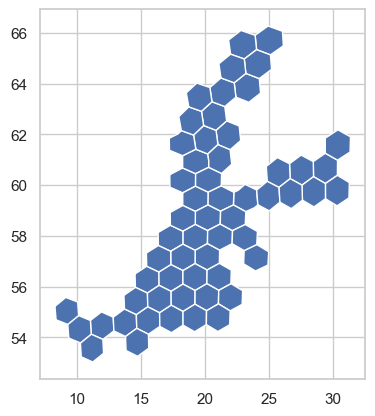

In [ ]:
gdf_sub[gdf_sub.cluster == 0].plot()

/var/folders/9w/q9wj71814bd5m3n9gpmxn1rm0000gn/T/ipykernel_24047/3762525360.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geom = gdf_sub[gdf_sub.cluster == cluster].buffer(0.001).unary_union
/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


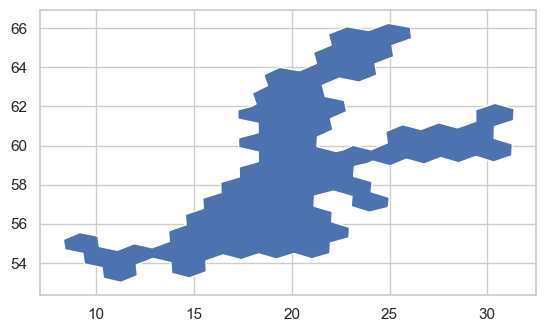

In [ ]:
cluster = 0
geom = gdf_sub[gdf_sub.cluster == cluster].buffer(0.001).unary_union
gdf_cluster_union = gpd.GeoDataFrame({'geometry': [geom]})
gdf_cluster_union.plot();

### Clustering on coordinates

In [ ]:
df.head()

,lon,lat,time,activity,h3_idx,activity_log
0,126.650000,27.966667,1991-01-08,2.764260,834b1dfffffffff,0.441579
1,125.000000,24.000000,1991-01-10,1.951489,834babfffffffff,0.290366
2,10.283333,54.483333,1991-01-10,55.129551,831f06fffffffff,1.741384
3,11.150000,54.600000,1991-01-10,52.121006,831f00fffffffff,1.717013
4,11.750000,54.416667,1991-01-10,59.520400,831f00fffffffff,1.774666


In [ ]:
from sklearn.cluster import DBSCAN, HDBSCAN
import numpy as np
from haversine import haversine, Unit

# Example coordinates: (latitude, longitude)
# coordinates = np.array([
#     [40.748817, -73.985428],  # Empire State Building
#     [40.689247, -74.044502],  # Statue of Liberty
#     [37.4189, -122.0819],     # Googleplex
#     [37.4275, -122.1697]      # Stanford University
# ])

coordinates = df[['lat', 'lon']].to_numpy()

# Convert latitude and longitude degrees to radians
coordinates_rad = np.radians(coordinates)

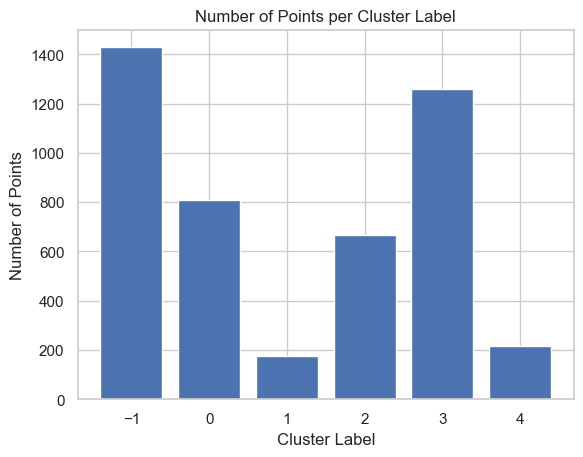

In [ ]:
# Define the epsilon distance (in kilometers)
epsilon = 100 / 6371.0088  # 100 km radius, divided by the Earth's radius in km to convert to radians

# Create a DBSCAN clusterer. Note that haversine distance requires data in the form of [lat, lon] and both in radians
# clusterer = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine')

clusterer = HDBSCAN(min_cluster_size=100, metric='haversine')

# Fit the clusterer to the data
cluster_labels = clusterer.fit_predict(coordinates_rad)

# Count the number of points per cluster
unique, counts = np.unique(cluster_labels, return_counts=True)

points_per_cluster = dict(zip(unique, counts))

# Create the bar plot
plt.bar(points_per_cluster.keys(), points_per_cluster.values())

plt.xlabel('Cluster Label')
plt.ylabel('Number of Points')
plt.title('Number of Points per Cluster Label')
plt.xticks(ticks=list(points_per_cluster.keys())); 

/Users/franckalbinet/mambaforge/envs/marisco/lib/python3.10/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


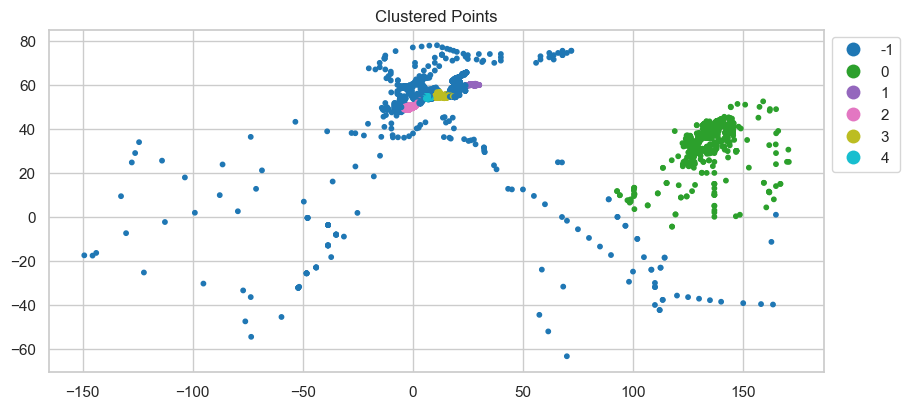

In [ ]:
data = {
    'Coordinates': [Point(lon, lat) for lat, lon in coordinates],
    'Cluster': cluster_labels
}

gdf = gpd.GeoDataFrame(data, geometry='Coordinates')
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax, column='Cluster', categorical=True, legend=True, 
         legend_kwds={'bbox_to_anchor': (1, 1)}, marker='o', markersize=10)

# Adjust the plot
ax.set_title('Clustered Points');

## Classical thematic mapping